### Contents
1 - Highlight dial area from larger photo <br>
2 - Align other dial based on template <br>
3 - Trial SSM similarity measure <br>

### 1 - Crop circular dial region from larger photo:

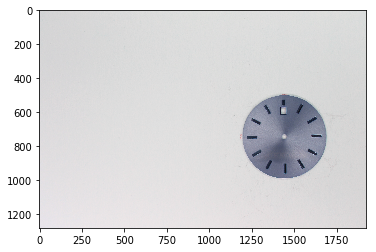

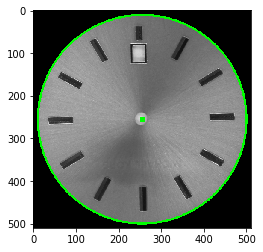

In [3]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim
from skimage import io
from skimage.filters import threshold_mean, gaussian
from skimage.util import img_as_ubyte
from skimage.color import gray2rgb

# grayscale conversion for cv functions:
def gray(pic):
    return cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)

def quick_fig(img):
    plt.figure(figsize=(16,5)) 
    plt.imshow(img)
    plt.axis("off")
    
# import 
img = cv2.imread("sample/good/g1.jpg")
plt.imshow(img)
plt.show()

def crop_circular_region(orig, use_mask=False, draw_outline=False, fixed_rect_size=255, rect_padding=10):
    """
    return largest circular region corresponding to watch dial
    """
    img_hough = gray(orig)
    # smooth image to make sure smaller features don't get captured as circles
    img_hough = img_as_ubyte(gaussian(img_hough, sigma=0.0))
    # ...and detect circles. 
    circ = cv2.HoughCircles(img_hough, cv2.cv.CV_HOUGH_GRADIENT, 1.4, 100)
    if circ is not None:
        circ = circ.squeeze()
        # sort potentially multiple circles and pick largest (by radius) as dial surface:
        if circ.size > 3:
            circ = circ[np.argmax(circ[:,2])]
        x,y,rad = circ.astype(int)
        img_hough = gray2rgb(img_hough)
        if use_mask: 
            # mask image outside circle, classifier should only pay attention to dial surface:
            yy,xx = np.ogrid[0:img_hough.shape[0], 0:img_hough.shape[1]]
            mask = (xx-x)**2 + (yy-y)**2 >= rad**2
            img_hough[mask] = (0,0,0)
        if draw_outline:
            # draw circle & center
            cv2.circle(img_hough, (x, y), rad, (0,255,0), 4)
            cv2.rectangle(img_hough, (x - 5, y - 5), (x + 5, y + 5), (0,255, 0), -1)
        # cropped_rect = img_hough[y-rect_size:y+rect_size, x-rect_size:x+rect_size]
        if not fixed_rect_size:
            rect_size = rad + rect_padding
            cropped_rect = img_hough[y-rect_size:y+rect_size, x-rect_size:x+rect_size]
        else:
            cropped_rect = img_hough[y-fixed_rect_size:y+fixed_rect_size, x-fixed_rect_size:x+fixed_rect_size]
        return cropped_rect
    else: 
        raise ValueError("No circular region found, consider adjusting hough parameters")

saved_rect = crop_circular_region(img, use_mask=True, draw_outline=True)


smpath = "sample/bad/"
for f in os.listdir(smpath):
    # print f
    pass
    # crp = img_as_ubyte(crop_circular_region(cv2.imread(smpath+f)))
    ### io.imsave("good_cropped/" + f[:-3]+"png", crp)
# io.imsave("b1.png", saved_rect)
# quick_fig(np.hstack([img, img_hough]))
plt.imshow(saved_rect)
plt.show()


(500, 500, 3)


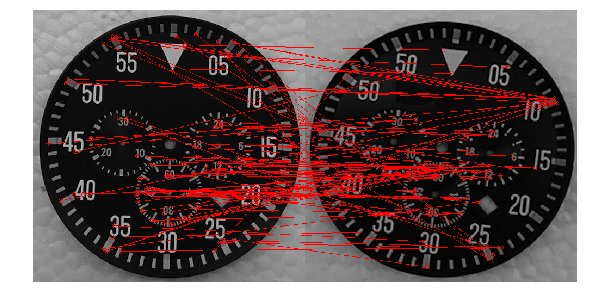

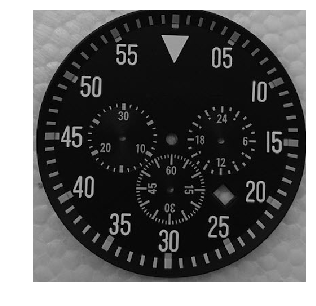

In [35]:
# export black dials:
black_good = cv2.imread("sample/black_dials/good.png")
black_bad = img = cv2.imread("sample/black_dials/bad.png")

print black_good.shape
def wop(orig, use_mask=False, draw_outline=False, fixed_rect_size=None, rect_padding=10):
    """
    return largest circular region corresponding to watch dial
    """
    if len(orig.shape)>2:
        img_hough = gray(orig)
    else:
        img_hough = orig
    # smooth image to make sure smaller features don't get captured as circles
    img_hough = img_as_ubyte(gaussian(img_hough, sigma=0.0))
    # ...and detect circles. 
    circ = cv2.HoughCircles(img_hough, cv2.cv.CV_HOUGH_GRADIENT, 1.4, 100)
    if circ is not None:
        circ = circ.squeeze()
        # sort potentially multiple circles and pick largest (by radius) as dial surface:
        if circ.size > 3:
            circ = circ[np.argmax(circ[:,2])]
        x,y,rad = circ.astype(int)
        img_hough = gray2rgb(img_hough)
        if use_mask: 
            # mask image outside circle, classifier should only pay attention to dial surface:
            yy,xx = np.ogrid[0:img_hough.shape[0], 0:img_hough.shape[1]]
            mask = (xx-x)**2 + (yy-y)**2 >= rad**2
            img_hough[mask] = (0,0,0)
        if draw_outline:
            # draw circle & center
            cv2.circle(img_hough, (x, y), rad, (0,255,0), 4)
            cv2.rectangle(img_hough, (x - 5, y - 5), (x + 5, y + 5), (0,255, 0), -1)
        # cropped_rect = img_hough[y-rect_size:y+rect_size, x-rect_size:x+rect_size]
        if not fixed_rect_size:
            rect_size = rad + rect_padding
            cropped_rect = img_hough[y-rect_size:y+rect_size, x-rect_size:x+rect_size]
        else:
            cropped_rect = img_hough[y-fixed_rect_size:y+fixed_rect_size, x-fixed_rect_size:x+fixed_rect_size]
        return cropped_rect
    else: 
        raise ValueError("No circular region found, consider adjusting hough parameters")

cropped_good = wop(black_good)
io.imsave("b1.png", saved_rect)
quick_fig(cropped_good)
plt.show()

### 2 - Align dial to template 
Calculate rotation/transformation to get standard dial position for later classification

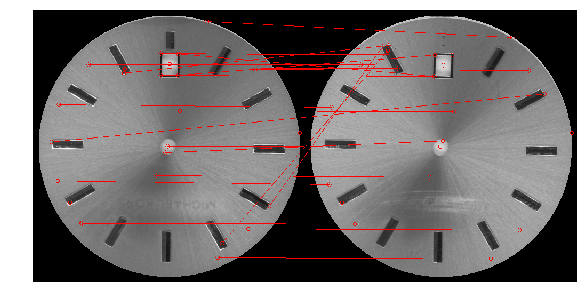

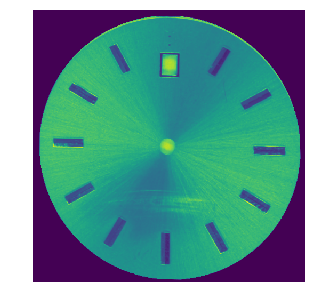

In [21]:
def drawMatches(img1, kp1, img2, kp2, matches):
    """
    Helper function for drawing image alignment feature matches (taken from opencv 3
    as not supported in cv 2.4)
    """
    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype="uint8")

    # Place the first image to the left
    out[:rows1, :cols1] = np.dstack([img1])

    # Place the next image to the right of it
    out[:rows2, cols1:] = np.dstack([img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:
        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour blue
        # thickness = 1
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points
        # thickness = 1
        # colour blue
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1)
    return out

def calculate_sift_matches(img1, img2, n_matches=100):
    """
    Take 2 images, calculate matching features and return comparison img + inverse transformation matrix
    """
    # Initiate SIFT detector
    sift = cv2.SIFT()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    MIN_MATCH_COUNT = 10
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # store good matches
    good_matches = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good_matches.append(m)

    if len(good_matches)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        inverse_transformation = np.linalg.inv(M)
        matchesMask = mask.ravel().tolist()

        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        tup = tuple(np.int32(dst)[1,0])
        # cv2.circle(img2, tup, 30, color=(0,255,0))
        # rectangle to visualise transform matrix
        ### 
        # cv2.polylines(img2,[np.int32(dst)],True,(0,255,0),5, cv2.CV_AA)
    else:
        print "Not enough matches are found - %d/%d" % (len(good_matches),MIN_MATCH_COUNT)
        matchesMask = None
        """
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)
        """
    # draw a max. of n_matches in the visualisation
    img3 = drawMatches(img1,kp1,img2,kp2,good_matches[:n_matches])
    return img3, inverse_transformation


img = gray(cv2.imread("good_cropped/masked/g6.png"))
bad = gray(cv2.imread("good_cropped/masked/b3.png"))

# try on single rotated image & ensemble image
# matched_rot_img, _ = calculate_sift_matches(img, img_rotated)
matched_ensemble_img, inv_m = calculate_sift_matches(img, bad)

recalibrated = cv2.warpPerspective(bad, inv_m, (510, 510))
quick_fig(matched_ensemble_img)
io.imsave("sample_match.png", recalibrated)
quick_fig(recalibrated)
plt.show()


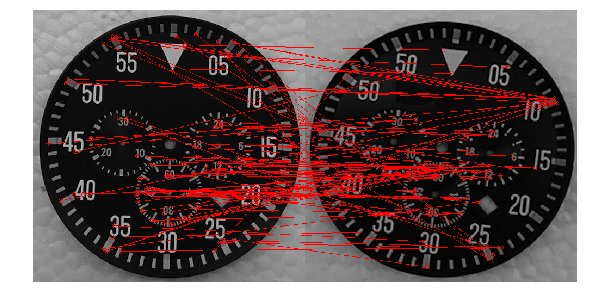

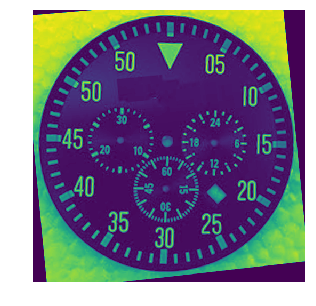

In [37]:
godo = gray(cv2.imread("sample/black_dials/good.png"))
bado = gray(cv2.imread("sample/black_dials/bad.png"))

# try on single rotated image & ensemble image
# matched_rot_img, _ = calculate_sift_matches(img, img_rotated)
MATCHO, INV_BLACK = calculate_sift_matches(godo, bado)

RECO = cv2.warpPerspective(bado, INV_BLACK, (510, 510))
quick_fig(MATCHO)
WECO = wop(RECO)
quick_fig(RECO)
io.imsave("macho_libre.png", RECO)
plt.show()

### 3 - Similarity Measure & Image comparison
These attempts didn't work as well due to offsets even with good image alignment.

(510, 510, 3) (510, 510, 3)


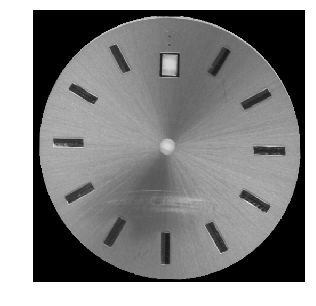

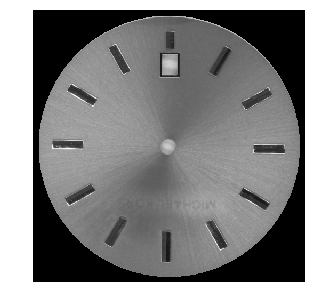

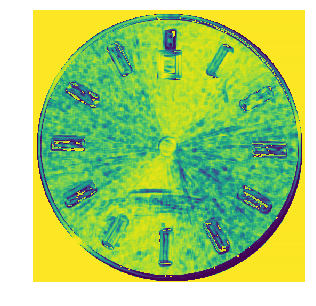

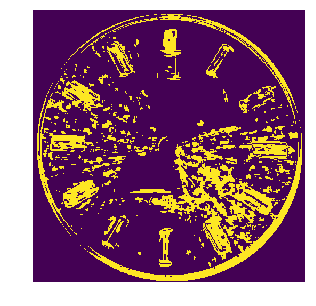

In [35]:
# load the two input images
imageA = cv2.imread("sample_match.png")
# imageA = cv2.imread("good_cropped/g1.png")
imageB = cv2.imread("good_cropped/masked/g6.png")

print imageA.shape, imageB.shape
# convert the images to grayscale
grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

# compute the Structural Similarity Index (SSIM) between the two
# images, ensuring that the difference image is returned
(score, diff) = compare_ssim(grayA, grayB, full=True)
diff = (diff * 255).astype("uint8")
# print("SSIM: {}".format(score))



# threshold the difference image, followed by finding contours to
# obtain the regions of the two input images that differ
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
# thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] 

# loop over the contours
for c in cnts:
    # compute the bounding box of the contour and then draw the
    # bounding box on both input images to represent where the two
    # images differ
    (x, y, w, h) = cv2.boundingRect(c)
    #print (x,y,w,h)
    # cv2.rectangle(imageA, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.rectangle(grayB, (x, y), (x + w, y + h), (0, 0, 255), 2)

# show the output images
quick_fig(imageA)
quick_fig(imageB)
quick_fig(diff)
quick_fig(thresh)
plt.show()